# Исследовательский анализ данных в Python и проверка гипотез.
- Автор:Таскаев Константин
- Дата: 30.06.2025
- ссылка на дашборд по первой части проекта: https://datalens.yandex/1opjgckjxe9wm

## Цели и задачи проекта

Провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.


## Описание данных
В нашем распоряжении данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года в виде двух датасетов:
Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. 
Датасет содержит такие поля:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- В данные также был добавлен столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Анализ данных в предыдущей части проекта показал, что выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Для удобства решения было бы корректно привести данные к одной валюте, например к российским рублям. Для этого в нашем распоряжении датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).
Используем эти данные для конвертации валюты.

## Содержимое проекта
Проведем исследовательский анализ данных, чтобы дать ответы на вопросы коллег. В ходе проекта будем работать с категориями событий, рассчитывать среднюю выручку с заказа и продажи одного билета в рублях, а также изучать распределение значений по категориям и периодам времени.

## План
- Шаг 1. Загрузка данных и знакомство с ними
- Шаг 2. Предобработка данных и подготовка их к исследованию
- Шаг 3. Исследовательский анализ данных:
  - Анализ распределения заказов по сегментам и их сезонные изменения
  - Осенняя активность пользователей
  - Популярные события и партнёры
- Шаг 4. Статистический анализ данных
- Шаг 5. Общий вывод и рекомендации


## 1. Загрузка данных и знакомство с ними

Загрузим данные трех датасетов:

In [1]:
# Импортируем библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import levene
from scipy.stats import mannwhitneyu

In [2]:
#Сформируем датафреймы:
final_tickets_orders_df = pd.read_csv('/datasets/final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv('/datasets/final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv('/datasets/final_tickets_tenge_df.csv')

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Благодарю за советы! Не помню, чтобы в спринте затрагивалась эта тема, а ведь это действительно важно знать заранее, чтобы уже на реальной работе быть готовым к ошибкам при выгрузке данных
</div>

In [3]:
#Отобразим первые 5 строк для знакомства с данными:
display(final_tickets_orders_df.head())
display(final_tickets_events_df.head())
display(final_tickets_tenge_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [4]:
#Проведем базовый анализ структуры данных датафрейма:
final_tickets_orders_df.info()
final_tickets_events_df.info()
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

- все данные соответствуют описанию;
- отсутствуют пропуски во всех столбцах, кроме столбца `days_since_prev` из датафрейма `final_tickets_orders_df` однако, как следует из описания - этот столбец содержит количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск;
- столбцы `created_dt_msk` и `created_ts_msk` из датафрейма `final_tickets_orders_df` содержат информацию с датами. Их следует привезти к типу datetime64.

In [5]:
#Приведем столбцы с датами к типу datetime
final_tickets_orders_df['created_dt_msk'] = pd.to_datetime(final_tickets_orders_df['created_dt_msk'])
final_tickets_orders_df['created_ts_msk'] = pd.to_datetime(final_tickets_orders_df['created_ts_msk'])
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])
#Проверим результат
final_tickets_orders_df.info()
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

- Окончательно убедимся, что в данных нет пропусков (кроме в столбца `days_since_prev`):

In [6]:
print(final_tickets_orders_df.isnull().sum())
print(final_tickets_events_df.isnull().sum())
print(final_tickets_tenge_df.isnull().sum())

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64
event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64
data       0
nominal    0
curs       0
cdx        0
dtype: int64


- Пропуски содержатся только в столбце `days_since_prev`

- Изучим столбцы с категориями

In [7]:
# Объединяем датафреймы
merged_df = final_tickets_orders_df.merge(final_tickets_events_df, on='event_id', how='left')

# Соединяем данные о курсе с основным датафреймом
merged_df = merged_df.merge(final_tickets_tenge_df[['data', 'curs']], left_on='created_dt_msk', right_on='data', how='left')
# Конвертируем kzt в рубли
merged_df['revenue_rub'] = merged_df.apply(lambda row: row['revenue'] * row['curs'] / 100 if row['currency_code'] == 'kzt' else row['revenue'], axis=1)
display(merged_df)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.94
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.45
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.57
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.49
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290844,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,...,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",2024-10-27,19.9266,965.57
290845,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,...,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",2024-10-27,19.9266,1448.36
290846,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,...,№4837,Каменевский регион,Глиногорск,213.0,3470.0,"Клуб киноманов ""Верность"" Лтд","пр. Титова, д. 5 стр. 68",2024-10-30,19.9516,178.95
290847,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,...,№998,Широковская область,Ягодиновка,239.0,2449.0,"Гильдия художников ""Флит"" Инк","пр. Макарова, д. 4",2024-09-24,19.3967,661.53


- Проверим уникальные значения в столбцах с категориями:

In [8]:
unique_values_1 = merged_df['device_type_canonical'].unique()
print(unique_values_1)
unique_values_2 = merged_df['cinema_circuit'].unique()
print(unique_values_2)
unique_values_3 = merged_df['age_limit'].unique()
print(unique_values_3)
unique_values_4 = merged_df['currency_code'].unique()
print(unique_values_4)
unique_values_5 = merged_df['service_name'].unique()
print(unique_values_5)
unique_values_6 = merged_df['event_type_description'].unique()
print(unique_values_6)
unique_values_7 = merged_df['event_type_main'].unique()
print(unique_values_7)
unique_values_7 = merged_df['region_name'].unique()
print(unique_values_7)

['mobile' 'desktop']
['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']
[16  0 18 12  6]
['rub' 'kzt']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' nan 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' nan 'ёлки']
['Каменевский регион' 'Североярская област

- 'cinema_circuit' - содержит значение "нет", которое, вероятно, можно интерпретировать, как отсутствие данных, которые закрыли заглушкой.
- 'event_type_description' - содержит значение "событие", которое, вероятно, можно интерпретировать, как отсутствие данных, которые закрыли заглушкой.
- 'event_type_main' и 'region_name' - содержит пропуск "nan"

In [9]:
#Проверяем количество пропусков в столбцах 'event_type_main' и 'region_name'
print(merged_df[['event_type_main', 'region_name']].isna().sum())


event_type_main    238
region_name        238
dtype: int64


In [10]:
#Удалим обнаруженные пропуски
merged_df = merged_df.dropna(subset=['event_type_main', 'region_name'])
#Проверяем наличие пропусков после удаления:
print(merged_df.isna().sum())

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
data                          0
curs                          0
revenue_rub                   0
dtype: int64


- Пропуски удалены. Остались пропуски только в столбце days_since_prev, которые мы не будем трогать, т.к. их наличие - оправдано.

### Изучим количественные значения по ключевым столбцам - `revenue` и `tickets_count`.
- Начнем с распределения. Поскольку у нас в датафрейме две валюты - разделим датафреймы на отдельные по значению rub и kzt для корректного анализа распределения:

In [11]:
df_rub = merged_df[merged_df['currency_code'] == 'rub']
df_kzt = merged_df[merged_df['currency_code'] == 'kzt']

- Посмотрим на статистические показатели df_rub['revenue']

In [12]:
df_rub['revenue'].describe()

count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

Промежуточный вывод:
- Средняя выручка (mean): 548.01. Это значение показывает среднее значение выручки по всем заказам.
- Стандартное отклонение (std): 871.75. Высокое стандартное отклонение указывает на то, что значения выручки сильно варьируются относительно среднего значения.
- Минимальное значение (min): -90.76. Отрицательное значение может указывать на ошибку в данных или на возвраты средств.
- Максимальное значение (max): 81 174.54. Это крайне высокое значение может быть выбросом и требует дополнительного анализа.

In [13]:
#Проверим отрицательные значения:
df_rub_sub_zero = df_rub[df_rub['revenue'] <0 ]
display(df_rub_sub_zero.head())


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
264,1594653,00eb3dc9baa1543,2024-06-29,2024-06-29 15:01:43,538650,нет,0,rub,mobile,-2.37,...,№4651,Берёзовская область,Златопольск,74.0,4593.0,"Центр традиционных ремесел ""Путь"" Инк","алл. Чайковского, д. 6 к. 691",2024-06-29,18.4198,-2.37
4540,2360920,02ea4583333f064,2024-09-03,2024-09-03 18:12:58,559772,нет,0,rub,mobile,-0.23,...,№1794,Широковская область,Лесореченск,21141.0,4108.0,"Театральные мастерские ""Лавровый"" Инк","бул. Карьерный, д. 820",2024-09-03,18.6868,-0.23
4562,2361094,02ea4583333f064,2024-09-04,2024-09-04 09:34:53,559772,нет,0,rub,mobile,-0.15,...,№1794,Широковская область,Лесореченск,21141.0,4108.0,"Театральные мастерские ""Лавровый"" Инк","бул. Карьерный, д. 820",2024-09-04,18.3640,-0.15
8155,166809,043f669c9f734b1,2024-09-27,2024-09-27 10:56:35,567183,нет,0,rub,mobile,-0.62,...,№3663,Золотоключевской край,Луговинец,20157.0,3085.0,"Арт-галерея ""Светлячок"" Инкорпорэйтед","пер. Попова, д. 72 стр. 770",2024-09-27,19.3256,-0.62
8156,166780,043f669c9f734b1,2024-09-27,2024-09-27 10:00:09,567183,нет,0,rub,mobile,-1.86,...,№3663,Золотоключевской край,Луговинец,20157.0,3085.0,"Арт-галерея ""Светлячок"" Инкорпорэйтед","пер. Попова, д. 72 стр. 770",2024-09-27,19.3256,-1.86


- В датафрейме действительно есть отрицательные значения. Вероятно, это связано с возвратами денежных средств.

- Проанализируем выбросы. Начнем с поиска 99-го процентиля:

In [14]:
ninety_ninth_percentile_rub = df_rub['revenue'].quantile(0.99)
print(ninety_ninth_percentile_rub)

2570.8


In [15]:
#Найдем все значения выше 99-го процентиля:
pd.set_option('display.max_columns', None)
more_then_ninety_ninth_percentile = df_rub[df_rub['revenue'] > 2570.8]
display(more_then_ninety_ninth_percentile.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
81,119771,00345f897f95a34,2024-10-23,2024-10-23 21:40:26,245958,нет,16,rub,mobile,2828.74,Край билетов,4,18858.25,0.0,d347788f-9353-4bd0-9732-2085425eafa8,спектакль,театр,№5019,Каменевский регион,Глиногорск,213.0,3900.0,"Цирковая студия ""Солнце"" и партнеры","алл. Тупиковая, д. 29",2024-10-23,20.0531,2828.74
119,7950467,006a3f73f3a6ed4,2024-08-13,2024-08-13 15:47:16,543440,нет,16,rub,desktop,2815.60,Прачечная,5,23463.30,NaN,9ccddda0-1c88-46c3-8042-19037888016e,фестиваль,концерты,№4649,Каменевский регион,Глиногорск,213.0,1082.0,"Гастрольный театр ""Магнит"" Лимитед","ш. Бригадное, д. 61 стр. 81",2024-08-13,18.8553,2815.60
211,2650369,00b0b535e645950,2024-10-08,2024-10-08 23:05:46,314894,нет,6,rub,mobile,2594.44,Билеты без проблем,4,17296.25,2.0,31502b0e-f241-48ed-8aef-4b5201eb0fd7,концерт,концерты,№4403,Малиновоярский округ,Верховино,197.0,4113.0,"Мастерская живого действия ""Гардероб"" Лимитед","ш. 30 лет Победы, д. 38 стр. 664",2024-10-08,19.9371,2594.44
325,7457235,00f4f5244501ce6,2024-10-12,2024-10-12 19:19:49,314894,нет,6,rub,mobile,2594.44,Билеты без проблем,4,17296.25,0.0,31502b0e-f241-48ed-8aef-4b5201eb0fd7,концерт,концерты,№4403,Малиновоярский округ,Верховино,197.0,4113.0,"Мастерская живого действия ""Гардероб"" Лимитед","ш. 30 лет Победы, д. 38 стр. 664",2024-10-12,19.5723,2594.44
433,8341851,0101ef3edcc444e,2024-10-23,2024-10-23 01:46:45,503635,нет,12,rub,desktop,2936.71,Билеты без проблем,5,29367.11,14.0,58a4dc53-7fe9-46a2-bf02-b782910ce2ec,концерт,концерты,№4524,Каменевский регион,Глиногорск,213.0,944.0,"Ремесленный центр ""Мороз"" Лимитед","ул. Черноморская, д. 32 к. 9/6",2024-10-23,20.0531,2936.71


- Вероятно, чем выше общая стоимость заказа, тем больше выручка. Это оправдывает наличие высоких значений выручки.

- Посмотрим на статистические показатели df_kzt['revenue']

In [16]:
df_kzt['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

Промежуточный вывод:
- Стандартное отклонение: 4 916.75, что указывает на значительный разброс выручки вокруг среднего значения.
- Максимальное значение (max): 26 425.86. Это высокое значение может быть выбросом и требует дополнительного анализа.

In [17]:
ninety_ninth_percentile_kzt = df_kzt['revenue'].quantile(0.99)
print(ninety_ninth_percentile_kzt)

17617.24


In [18]:
more_then_ninety_ninth_percentile_kzt = df_kzt[df_kzt['revenue'] > 17617.24]
display(more_then_ninety_ninth_percentile_kzt.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
289,720419,00f4f5244501ce6,2024-06-11,2024-06-11 20:15:57,536826,нет,12,kzt,mobile,22021.55,Мой билет,5,275269.4,NaN,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерт,концерты,№4950,Верхоречная область,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",2024-06-11,19.8928,4380.702898
822,4451269,019fa401ddb00aa,2024-06-11,2024-06-11 12:33:38,536826,нет,12,kzt,mobile,22021.55,Мой билет,5,275269.4,2.0,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерт,концерты,№4950,Верхоречная область,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",2024-06-11,19.8928,4380.702898
3340,4794049,02ea4583333f064,2024-06-11,2024-06-11 13:55:54,536825,нет,12,kzt,mobile,20676.39,Мой билет,6,344606.5,0.0,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерт,концерты,№4950,Шанырский регион,Широковка,162.0,2169.0,"Кладбище искусств ""Феномен"" Инк","ш. Саратовское, д. 73 стр. 367",2024-06-11,19.8928,4113.112910
11304,3688888,066dbc1c7d3b89c,2024-06-19,2024-06-19 12:07:08,536826,нет,12,kzt,desktop,22021.55,Мой билет,5,275269.4,6.0,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерт,концерты,№4950,Верхоречная область,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",2024-06-19,19.2165,4231.771156
15064,4142477,0beb8fc0c0a9ce1,2024-06-11,2024-06-11 12:36:11,536825,нет,12,kzt,desktop,20676.39,Мой билет,6,344606.5,0.0,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерт,концерты,№4950,Шанырский регион,Широковка,162.0,2169.0,"Кладбище искусств ""Феномен"" Инк","ш. Саратовское, д. 73 стр. 367",2024-06-11,19.8928,4113.112910


- Вывод, как и по df_rub - чем выше общая стоимость заказа, тем больше выручка. Это оправдывает наличие высоких значений выручки.

- Проведем аналогичный анализ по столбцу `tickets_count`

In [19]:
df_rub['tickets_count'].describe()

count    285542.000000
mean          2.754159
std           1.171575
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Промежуточные выводы:
- Стандартное отклонение: 1.17, что указывает на относительно небольшой разброс количества билетов вокруг среднего значения.
- Максимальное количество билетов в одном заказе: 57, что является значительным отклонением от среднего значения и может указывать на наличие выбросов в данных.

In [20]:
ninety_ninth_percentile_tickets_rub = df_rub['tickets_count'].quantile(0.99)
print(ninety_ninth_percentile_tickets_rub)

6.0


In [21]:
more_then_ninety_ninth_percentile_tickets_rub  = df_rub[df_rub['tickets_count'] > 6]
display(more_then_ninety_ninth_percentile_tickets_rub.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
1153,4486939,019fa401ddb00aa,2024-09-13,2024-09-13 12:19:52,562954,нет,18,rub,mobile,1260.62,Билеты без проблем,10,25212.40,0.0,b6a34397-5581-4d0d-8ee7-62e9852ac06c,концерт,концерты,№4520,Североярская область,Озёрск,2.0,924.0,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",2024-09-13,19.0758,1260.62
2860,1692296,0263f0dddb290b6,2024-10-21,2024-10-21 22:40:19,586844,нет,0,rub,mobile,1231.70,Мой билет,9,41056.56,NaN,0aeb1f89-dfc3-4171-bfaa-e1960df7f37a,событие,другое,№4434,Североярская область,Озёрск,2.0,924.0,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",2024-10-21,19.7884,1231.70
5015,4057710,02ea4583333f064,2024-09-24,2024-09-24 17:13:23,446456,нет,18,rub,mobile,1225.61,Билеты без проблем,7,40853.51,0.0,9d3e6cf4-0e79-47a3-a632-3f058d32ddfc,событие,другое,№4520,Североярская область,Озёрск,2.0,924.0,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",2024-09-24,19.3967,1225.61
10483,6301150,05ba93f1b1e1fdd,2024-08-17,2024-08-17 14:25:06,555072,нет,18,rub,mobile,582.78,Билеты без проблем,7,19425.86,1.0,ce448a71-45ad-4254-8292-062bdea65755,событие,другое,№4520,Североярская область,Озёрск,2.0,924.0,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",2024-08-17,18.5775,582.78
12407,3769624,07fac55c42e3414,2024-06-13,2024-06-13 22:54:44,529629,нет,18,rub,mobile,877.70,Билеты без проблем,7,21942.48,1.0,30e84abc-b350-4a7d-a54b-5943680b54b0,событие,другое,№4520,Североярская область,Озёрск,2.0,924.0,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",2024-06-13,19.8655,877.70


- Предполагаю, что наличие заказов с большим количеством билетов также возможно, т.к. не исключено, что билеты покупала целая организация на своих сотрудников.

In [22]:
df_kzt['tickets_count'].describe()

count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64

В этом случае данные распределены равномерно: стандартное отклонение не высокое, среднее значение примерно равно медиане и максимальное значение недалеко от 75-го процентиля.

- Построим гистограммы распределения значений и диаграммы размаха отдельно для rub и kzt - начнем со столбца `revenue`

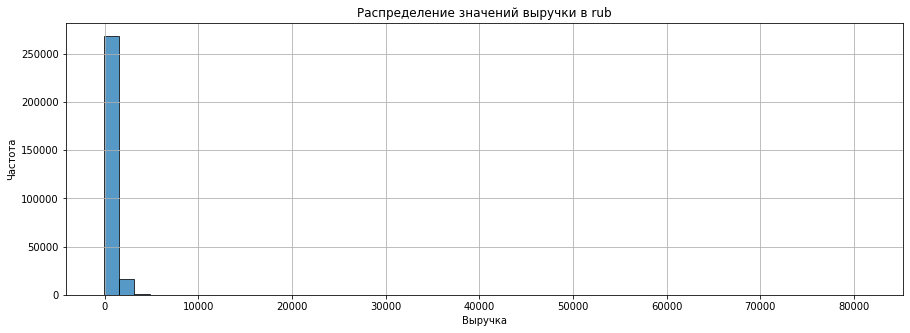

In [23]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_rub['revenue'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин - всего 50
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений выручки в rub')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

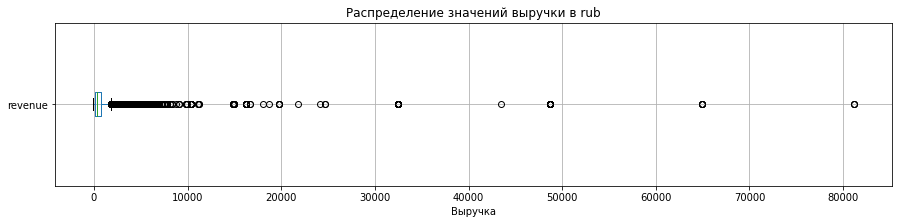

In [24]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 3))

# Строим диаграмму размаха значений в столбце revenue
df_rub.boxplot(column='revenue', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений выручки в rub')
plt.xlabel('Выручка')

# Выводим график
plt.show()

Данные с широким разбросом и «хвостом» в правой части гистограммы. Такие высокие значения можно отнести к выбросам. Однако сами значения, не выглядят ошибкой, и такое значение выручки вполне реально (например, если некие организации заказывают билеты на всех своих сотрудников, либо компании, которые проводят корпоративные мероприятия для предприятий, получают деньги от заказчика и берет на себя закупку билетов на то или иное мероприятие). 

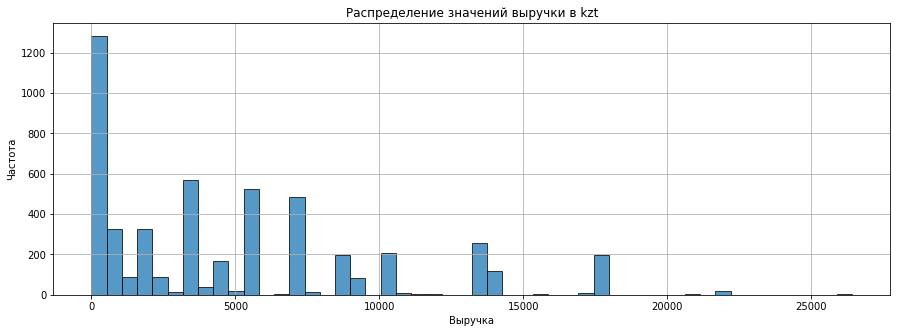

In [25]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_kzt['revenue'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин - всего 50
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений выручки в kzt')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

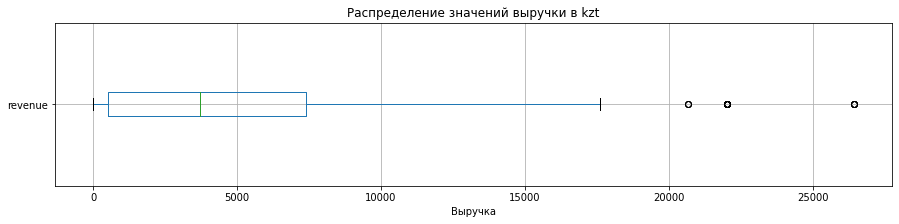

In [26]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 3))

# Строим диаграмму размаха значений в столбце revenue
df_kzt.boxplot(column='revenue', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений выручки в kzt')
plt.xlabel('Выручка')

# Выводим график
plt.show()

- По kzt данные распределены более равномерно, но также с хвостом в правой части гистограммы. Выбросов не так много(но и в этом случае, я не считаю, что это выбросы по той же логике, что и по заказам в рублях по графикам выше), но и заказов в тенге значительно меньше, относительно заказов в рублях.

- Теперь сделаем те же графики для столбца `tickets_count`

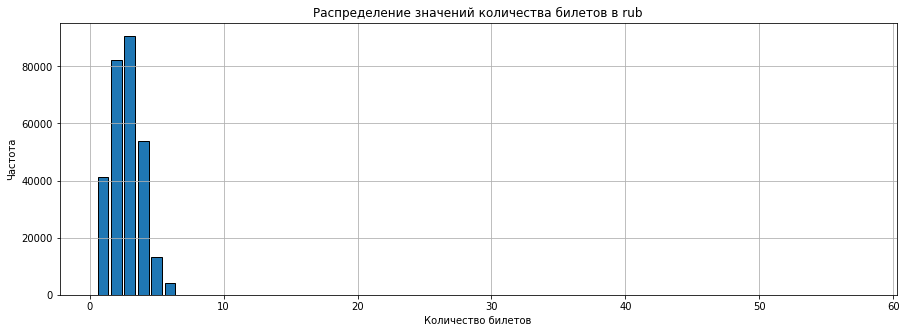

In [27]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Подсчитываем количество билетов в каждой категории
ticket_counts = df_rub['tickets_count'].value_counts().sort_index()

# Строим график
plt.bar(ticket_counts.index, ticket_counts.values, edgecolor='black')

# Настраиваем оформление графика
plt.title('Распределение значений количества билетов в rub')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.grid()

# Выводим график
plt.show()

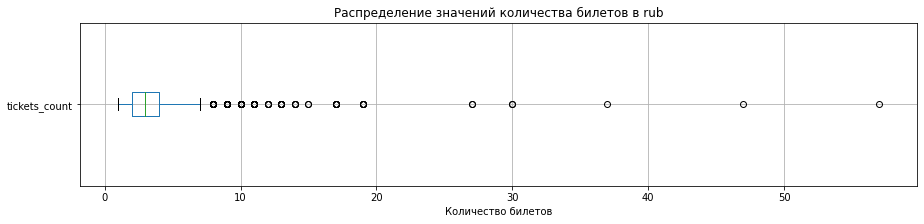

In [28]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 3))

# Строим диаграмму размаха значений в столбце revenue
df_rub.boxplot(column='tickets_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества билетов в rub')
plt.xlabel('Количество билетов')

# Выводим график
plt.show()

- по столбцу `tickets_count` данные содержат выбросы в правой части диаграммы размаха. Такие высокие значения можно отнести к выбросам, однако сами значения - не выглядят ошибкой, и такое значение выручки вполне реально (например, если некие организации заказывают билеты на всех своих сотрудников, либо компании, которые проводят корпоративные мероприятия для предприятий, получают деньги от заказчика и берет на себя закупку билетов на то или иное мероприятие). 

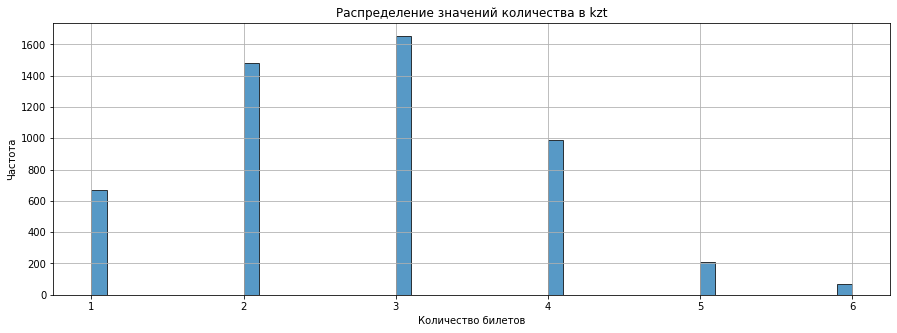

In [29]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df_kzt['tickets_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин - всего 50
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений количества в kzt')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

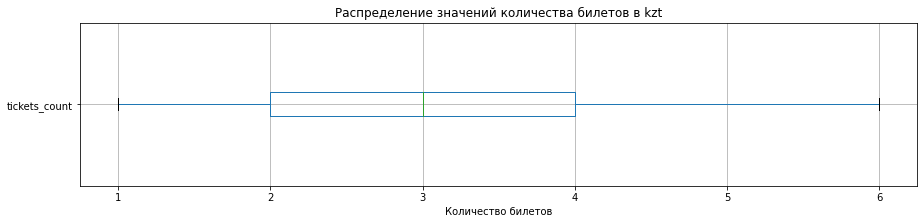

In [30]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 3))

# Строим диаграмму размаха значений в столбце revenue
df_kzt.boxplot(column='tickets_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества билетов в kzt')
plt.xlabel('Количество билетов')

# Выводим график
plt.show()

- Графики по количеству билетов по заказам в тенге напоминают нормальное распределение значений

### Вывод по распределению значений:
- С одной стороны, я не считаю данные за пределами 99-го процентиля выбросами, т.к. такие крупные заказы действительно могут быть. Но поскольку такие высокие значения могут исказить общий анализ данных - принимаю решение от них избавиться.

In [31]:
df_rub = df_rub[(df_rub['revenue'] <= ninety_ninth_percentile_rub) & (df_rub['revenue'] > 0) & (df_rub['tickets_count'] <= ninety_ninth_percentile_tickets_rub) & (df_rub['tickets_count'] > 0)]
df_kzt= df_kzt[(df_kzt['revenue'] <= ninety_ninth_percentile_kzt) & (df_kzt['revenue'] > 0) & (df_kzt['tickets_count'] > 0)]
final_df = pd.concat([df_rub, df_kzt], ignore_index=True)
display(final_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.94
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.45
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.57
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.49
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.41


### Проверка наличия дубликатов

In [32]:
#Проверим наличие явных дубликатов
duplicates = final_df[final_df.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [order_id, user_id, created_dt_msk, created_ts_msk, event_id, cinema_circuit, age_limit, currency_code, device_type_canonical, revenue, service_name, tickets_count, total, days_since_prev, event_name, event_type_description, event_type_main, organizers, region_name, city_name, city_id, venue_id, venue_name, venue_address, data, curs, revenue_rub]
Index: []


- Явных дубликатов не обнаружено

In [33]:
#Проверим наличие неявных дубликатов по всем признакам, кроме order_id
columns_to_check = final_df.columns.drop('order_id')
special_duplicates = final_df[final_df.duplicated(subset=columns_to_check, keep=False)]
print(special_duplicates.shape[0])
display(special_duplicates.head())

56


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub
11237,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2024-08-13,18.8553,69.82
11238,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2024-08-13,18.8553,69.82
54771,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",2024-10-30,19.9516,11.23
54774,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",2024-10-30,19.9516,11.23
80204,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",2024-06-25,18.8012,59.19


- Обнаружено 56 неявных дубликатов. Удалим их:

In [34]:
final_df = final_df.drop_duplicates(subset=columns_to_check, keep='first')
# Проверим результат удаления:
columns_to_check = final_df.columns.drop('order_id')
special_duplicates = final_df[final_df.duplicated(subset=columns_to_check, keep=False)]
print(special_duplicates.shape[0])
display(special_duplicates.head())

0


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub


- Удаление прошло успешно. Еще раз ознакомимся с типами данных в итоговом датафрейме

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281672 entries, 0 to 281700
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                281672 non-null  int64         
 1   user_id                 281672 non-null  object        
 2   created_dt_msk          281672 non-null  datetime64[ns]
 3   created_ts_msk          281672 non-null  datetime64[ns]
 4   event_id                281672 non-null  int64         
 5   cinema_circuit          281672 non-null  object        
 6   age_limit               281672 non-null  int64         
 7   currency_code           281672 non-null  object        
 8   device_type_canonical   281672 non-null  object        
 9   revenue                 281672 non-null  float64       
 10  service_name            281672 non-null  object        
 11  tickets_count           281672 non-null  int64         
 12  total                   281672

- Снизим разрядность количественных данных:

In [36]:
# Список столбцов, которые нужно преобразовать
columns_to_convert = ['order_id', 'event_id', 'age_limit', 'city_id', 'tickets_count', 'venue_id']

# Применяем преобразование ко всем выбранным столбцам
final_df[columns_to_convert] = final_df[columns_to_convert].apply(pd.to_numeric, downcast='integer')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281672 entries, 0 to 281700
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                281672 non-null  int32         
 1   user_id                 281672 non-null  object        
 2   created_dt_msk          281672 non-null  datetime64[ns]
 3   created_ts_msk          281672 non-null  datetime64[ns]
 4   event_id                281672 non-null  int32         
 5   cinema_circuit          281672 non-null  object        
 6   age_limit               281672 non-null  int8          
 7   currency_code           281672 non-null  object        
 8   device_type_canonical   281672 non-null  object        
 9   revenue                 281672 non-null  float64       
 10  service_name            281672 non-null  object        
 11  tickets_count           281672 non-null  int8          
 12  total                   281672

- Создадим несколько новых столбцов:
  - one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.
  - month — выделим месяц оформления заказа в отдельный столбец.
  - season — создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [37]:
#Вычисляем выручку с одного билета по меропиятию
final_df['one_ticket_revenue_rub'] = final_df['revenue_rub'] / final_df['tickets_count']
display(final_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.41,463.4700


In [38]:
#Создаем столбец с месяцем, вытягивая месяц из даты в столбце created_dt_msk
final_df['month'] = final_df['created_dt_msk'].dt.month
final_df['month'] = pd.to_numeric(final_df['month'], downcast='integer')
display(final_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.94,380.4850,8
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.45,144.7250,7
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.57,314.6425,10
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.49,4.2450,7
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.41,463.4700,10


In [39]:
#Сформируем функцию для формирования категорий по месяцам
def determine_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

final_df['season'] = final_df['created_dt_msk'].dt.month.apply(determine_season)
display(final_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.6972,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.3419,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.6475,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.5010,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.6648,1390.41,463.4700,10,осень


In [40]:
#Посмотрим на итоговый датафрейм
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281672 entries, 0 to 281700
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                281672 non-null  int32         
 1   user_id                 281672 non-null  object        
 2   created_dt_msk          281672 non-null  datetime64[ns]
 3   created_ts_msk          281672 non-null  datetime64[ns]
 4   event_id                281672 non-null  int32         
 5   cinema_circuit          281672 non-null  object        
 6   age_limit               281672 non-null  int8          
 7   currency_code           281672 non-null  object        
 8   device_type_canonical   281672 non-null  object        
 9   revenue                 281672 non-null  float64       
 10  service_name            281672 non-null  object        
 11  tickets_count           281672 non-null  int8          
 12  total                   281672

### Вывод после предобработки данных
- Объединили датафреймы в один
- Удалили выбросы, оставив данные по значениям в столбцах revenue и tickets_count больше 0 по 99й процентиль
- Удалили дубликаты
- Оптимизировали типы данных и уменьшили разрядность количественных значений
- Создали несколько новых столбцов:
  - revenue_rub - сконвертировали валюту из тенге в рубли и оставили значения, которые изначально были в рублях
  - one_ticket_revenue_rub - выручка с одного билета по мероприятиям
  - month - месяц оформления заказа
  - season - сезон оформления заказа
- После всех фильтраций оставили 281700 строк.

## Исследовательский анализ данных

## Анализ распределения заказов по сегментам и их сезонные изменения

### Изучим изменение пользовательской активности в связи с сезонностью. 

- Для каждого месяца найдем количество заказов и визуализируем результаты.

In [41]:
grouped = final_df.groupby('month').agg({'order_id': 'count'}, ascending = False).reset_index()
display(grouped)

,month,order_id
0,6,32882
1,7,37855
2,8,43139
3,9,68852
4,10,98944


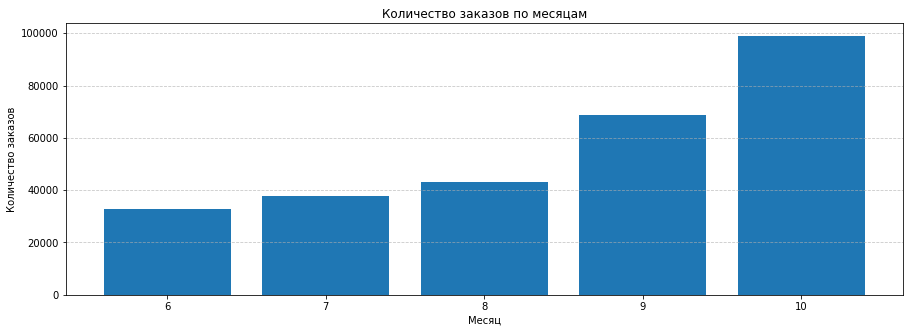

In [42]:
plt.figure(figsize=(15, 5))  # Размер фигуры
plt.bar(grouped['month'], grouped['order_id'])
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Как видим - количество заказов увеличивается с каждым месяцем

- Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

In [43]:
final_df_summer = final_df[final_df['season'] == 'лето']
grouped_by_event_type_summer = final_df_summer.groupby('event_type_main').agg({'order_id': 'count'}) / final_df_summer['order_id'].count() 
grouped_by_event_type_summer.sort_values(by='event_type_main', ascending=True, inplace=True)
display(grouped_by_event_type_summer)

,order_id
event_type_main,
выставки,0.021137
другое,0.249543
концерты,0.438916
спорт,0.024237
стендап,0.055727
театр,0.208042
ёлки,0.002397


In [44]:
final_df_autumn = final_df[final_df['season'] == 'осень']
grouped_by_event_type_autumn = final_df_autumn.groupby('event_type_main').agg({'order_id': 'count'}) / final_df_autumn['order_id'].count()
grouped_by_event_type_autumn.sort_values(by='event_type_main', ascending=True, inplace=True)
display(grouped_by_event_type_autumn)

,order_id
event_type_main,
выставки,0.014315
другое,0.194272
концерты,0.373757
спорт,0.111844
стендап,0.041258
театр,0.254488
ёлки,0.010066


In [45]:
grouped_by_device_type_summer = final_df_summer.groupby('device_type_canonical').agg({'order_id': 'count'}) / final_df_summer['order_id'].count()
grouped_by_device_type_summer.sort_values(by='order_id', ascending=True, inplace=True)
grouped_by_device_type_summer.sort_values(by='device_type_canonical', ascending=True, inplace=True)
display(grouped_by_device_type_summer)

,order_id
device_type_canonical,
desktop,0.191041
mobile,0.808959


In [46]:
grouped_by_device_type_autumn = final_df_autumn.groupby('device_type_canonical').agg({'order_id': 'count'}) / final_df_autumn['order_id'].count() 
grouped_by_device_type_autumn.sort_values(by='order_id', ascending=True, inplace=True)
grouped_by_device_type_autumn.sort_values(by='device_type_canonical', ascending=True, inplace=True)
display(grouped_by_device_type_autumn)

,order_id
device_type_canonical,
desktop,0.203771
mobile,0.796229


In [47]:
grouped_by_age_limit_summer = final_df_summer.groupby('age_limit').agg({'order_id': 'count'}) / final_df_summer['order_id'].count() 
grouped_by_age_limit_summer.sort_values(by='order_id', ascending=True, inplace=True)
grouped_by_age_limit_summer.sort_values(by='age_limit', ascending=True, inplace=True)
display(grouped_by_age_limit_summer)

,order_id
age_limit,
0,0.181311
6,0.183357
12,0.212547
16,0.284353
18,0.138431


In [48]:
grouped_by_age_limit_autumn = final_df_autumn.groupby('age_limit').agg({'order_id': 'count'}) / final_df_autumn['order_id'].count() 
grouped_by_age_limit_autumn.sort_values(by='order_id', ascending=True, inplace=True)
grouped_by_age_limit_autumn.sort_values(by='age_limit', ascending=True, inplace=True)
display(grouped_by_age_limit_autumn)

,order_id
age_limit,
0,0.233998
6,0.176512
12,0.221787
16,0.263439
18,0.104264


- Построим визуализации

,order_id
event_type_main,
выставки,0.021137
другое,0.249543
концерты,0.438916
спорт,0.024237
стендап,0.055727
театр,0.208042
ёлки,0.002397


,order_id
event_type_main,
выставки,0.014315
другое,0.194272
концерты,0.373757
спорт,0.111844
стендап,0.041258
театр,0.254488
ёлки,0.010066


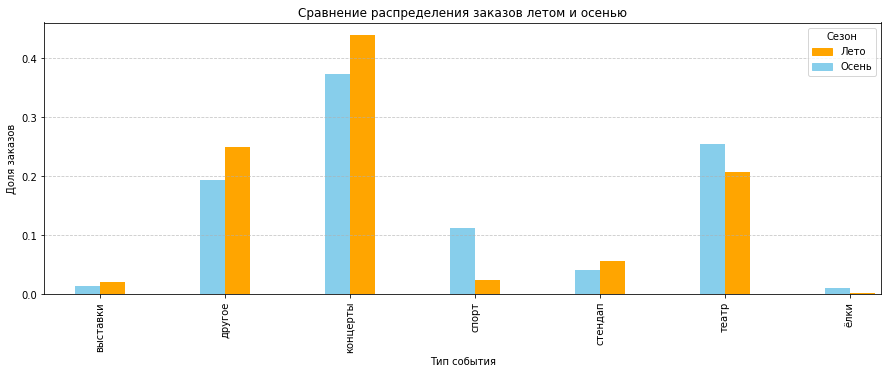

In [49]:
# Построение столбчатой диаграммы
plt.figure(figsize=(15, 5))  # Размер фигуры
ax = plt.gca()  # Получаем текущий axes

# Ширина столбцов
bar_width = 0.2
# Получаем все уникальные типы событий т.к. летом и осенью было разное количество событий - для корректного сравнения нам нужно, чтобы присутсвовало одинаковое количество строк в каждом датафрейме
all_events = grouped_by_event_type_summer.index.union(grouped_by_event_type_autumn.index)

# Заполняем пропущенные значения нулями
grouped_by_event_type_summer = grouped_by_event_type_summer.reindex(all_events, fill_value=0)
display(grouped_by_event_type_summer)
grouped_by_event_type_autumn = grouped_by_event_type_autumn.reindex(all_events, fill_value=0)
display(grouped_by_event_type_autumn)
data_to_plot = pd.concat([grouped_by_event_type_summer, grouped_by_event_type_autumn], keys=['Лето', 'Осень'])


# Рисуем столбцы для летнего периода
data_to_plot.loc['Лето'].plot(kind='bar', color='orange', ax=ax, label='Лето', width=bar_width, position=0)

# Рисуем столбцы для осеннего периода
data_to_plot.loc['Осень'].plot(kind='bar', color='skyblue', ax=ax, label='Осень', width=bar_width, position=1)

plt.title('Сравнение распределения заказов летом и осенью')
plt.xlabel('Тип события')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
# После построения графиков
plt.legend(handles=[mpatches.Patch(color='orange', label='Лето'), mpatches.Patch(color='skyblue', label='Осень')], title='Сезон')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

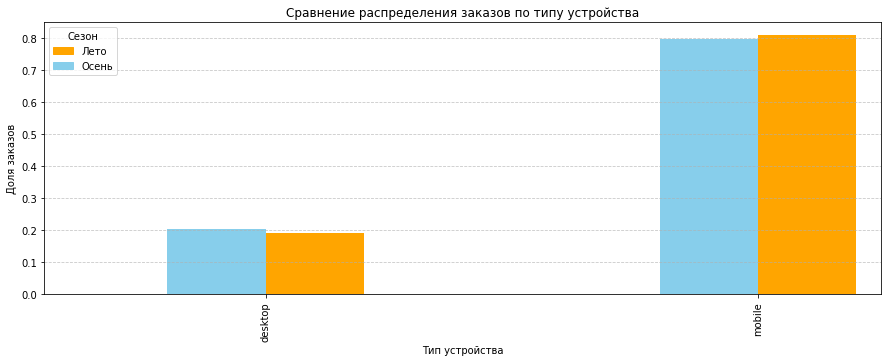

In [50]:
# Построение столбчатой диаграммы
plt.figure(figsize=(15, 5))  # Размер фигуры
ax = plt.gca()  # Получаем текущий axes

# Ширина столбцов
bar_width = 0.2
data_to_plot = pd.concat([grouped_by_device_type_summer, grouped_by_device_type_autumn], keys=['Лето', 'Осень'])


# Рисуем столбцы для летнего периода
data_to_plot.loc['Лето'].plot(kind='bar', color='orange', ax=ax, label='Лето', width=bar_width, position=0)

# Рисуем столбцы для осеннего периода
data_to_plot.loc['Осень'].plot(kind='bar', color='skyblue', ax=ax, label='Осень', width=bar_width, position=1)

plt.title('Сравнение распределения заказов по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
# После построения графиков
plt.legend(handles=[mpatches.Patch(color='orange', label='Лето'), mpatches.Patch(color='skyblue', label='Осень')], title='Сезон')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

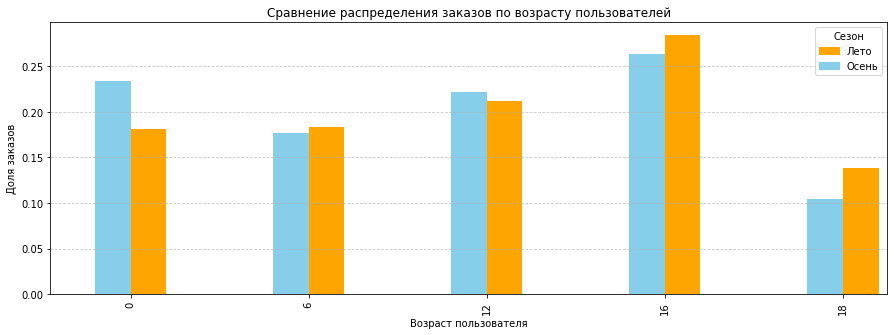

In [51]:
# Построение столбчатой диаграммы
plt.figure(figsize=(15, 5))  # Размер фигуры
ax = plt.gca()  # Получаем текущий axes

# Ширина столбцов
bar_width = 0.2
data_to_plot = pd.concat([grouped_by_age_limit_summer, grouped_by_age_limit_autumn], keys=['Лето', 'Осень'])


# Рисуем столбцы для летнего периода
data_to_plot.loc['Лето'].plot(kind='bar', color='orange', ax=ax, label='Лето', width=bar_width, position=0)

# Рисуем столбцы для осеннего периода
data_to_plot.loc['Осень'].plot(kind='bar', color='skyblue', ax=ax, label='Осень', width=bar_width, position=1)

plt.title('Сравнение распределения заказов по возрасту пользователей')
plt.xlabel('Возраст пользователя')
plt.ylabel('Доля заказов')
plt.legend(title='Сезон')
# После построения графиков
plt.legend(handles=[mpatches.Patch(color='orange', label='Лето'), mpatches.Patch(color='skyblue', label='Осень')], title='Сезон')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

In [52]:
#Считаем среднюю выручку с одного билета летом в зависимости от мероприятия:
grouped_by_event_type_summer_revenue_per_ticket = final_df_summer.groupby('event_type_main').agg({'revenue_rub': 'sum', 'tickets_count':'sum'})
grouped_by_event_type_summer_revenue_per_ticket = grouped_by_event_type_summer_revenue_per_ticket['revenue_rub']/grouped_by_event_type_summer_revenue_per_ticket['tickets_count']
display(grouped_by_event_type_summer_revenue_per_ticket)

event_type_main
выставки     89.531485
другое       92.546028
концерты    307.726293
спорт        54.628063
стендап     215.220898
театр       213.636231
ёлки        263.499330
dtype: float64

In [53]:
#Считаем среднюю выручку с одного билета осенью в зависимости от мероприятия:
grouped_by_event_type_autumn_revenue_per_ticket = final_df_autumn.groupby('event_type_main').agg({'revenue_rub': 'sum', 'tickets_count':'sum'})
grouped_by_event_type_autumn_revenue_per_ticket = grouped_by_event_type_autumn_revenue_per_ticket['revenue_rub']/grouped_by_event_type_autumn_revenue_per_ticket['tickets_count']
display(grouped_by_event_type_autumn_revenue_per_ticket)

event_type_main
выставки     93.462303
другое       83.185685
концерты    269.789862
спорт        50.199369
стендап     228.673568
театр       176.522422
ёлки        217.891186
dtype: float64

- Объединим датафреймы и посчитаем относительную разницу в выручке с одного билета летом и осенью

In [54]:
#Выделим уникальные значения из обоих датафреймов
all_events_revenue_per_ticket_by_season = grouped_by_event_type_summer_revenue_per_ticket.index.union(grouped_by_event_type_autumn_revenue_per_ticket)
# Заполняем пропущенные значения в отдельных датафреймах нулями
grouped_by_event_type_summer_revenue_per_ticket = grouped_by_event_type_summer_revenue_per_ticket.reindex(all_events, fill_value=0)
display(grouped_by_event_type_summer_revenue_per_ticket)
grouped_by_event_type_autumn_revenue_per_ticket = grouped_by_event_type_autumn_revenue_per_ticket.reindex(all_events, fill_value=0)
display(grouped_by_event_type_autumn_revenue_per_ticket)
# Объединяем получившиеся датафреймы
revenue_per_ticket_by_season = pd.concat([grouped_by_event_type_summer_revenue_per_ticket, grouped_by_event_type_autumn_revenue_per_ticket], axis=1, keys=['Лето', 'Осень'])
# Посчитаем относительную разницу в выручке с одного билета летом и осенью
revenue_per_ticket_by_season['delta_between_season'] = revenue_per_ticket_by_season.apply(lambda x: 100 if x['Лето'] == 0 else round(((x['Осень'] / x['Лето']) * 100 - 100), 2), axis=1)
display(revenue_per_ticket_by_season)



event_type_main
выставки     89.531485
другое       92.546028
концерты    307.726293
спорт        54.628063
стендап     215.220898
театр       213.636231
ёлки        263.499330
dtype: float64

event_type_main
выставки     93.462303
другое       83.185685
концерты    269.789862
спорт        50.199369
стендап     228.673568
театр       176.522422
ёлки        217.891186
dtype: float64

,Лето,Осень,delta_between_season
event_type_main,,,
выставки,89.531485,93.462303,4.39
другое,92.546028,83.185685,-10.11
концерты,307.726293,269.789862,-12.33
спорт,54.628063,50.199369,-8.11
стендап,215.220898,228.673568,6.25
театр,213.636231,176.522422,-17.37
ёлки,263.499330,217.891186,-17.31


- Визуализируем полученные результаты

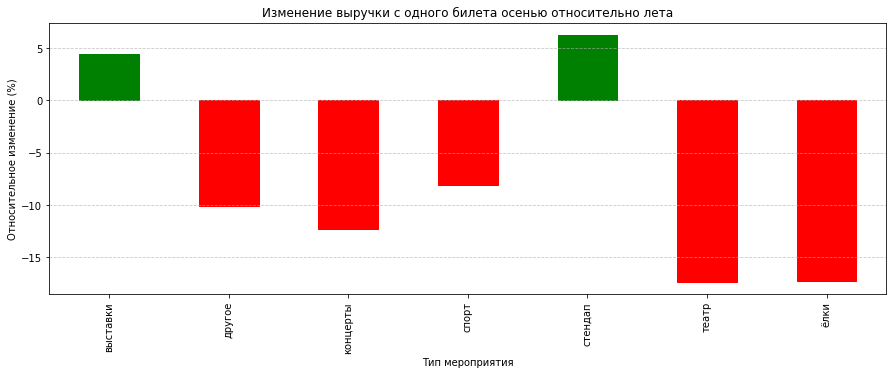

In [55]:
plt.figure(figsize=(15, 5))
ax = revenue_per_ticket_by_season['delta_between_season'].plot(kind='bar')

# Задаем цвета для столбцов с положительными и отрицательными значенниями
colors = ['green' if val > 0 else 'red' for val in revenue_per_ticket_by_season['delta_between_season']]
for bar, color in zip(ax.containers[0], colors):
    bar.set_color(color)

plt.title('Изменение выручки с одного билета осенью относительно лета')
plt.xlabel('Тип мероприятия')
plt.ylabel('Относительное изменение (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





### Общие выводы по двум предыдущим пунктам:
- Выделим наиболее отличающиеся значения по выделенным группам между сезонами лето/осень с наибольшими объемами:
  - Тип мероприятия:
     - Концерты - летом количество концертов выше, чем осенью - доля заказов 0.44 летом против 0.37 осенью
     - Театры - осенью количество спектаклей выше, чем осенью - доля заказов 0.25 осенью против 0.21 летом
     - Также есть разница по типу "другое", но его не будем брать в расчет, т.к. нет понимания, что конкретно подразумевается под "другое", т.к. это, вероятно, заглушка, которая закрывает те строки, по которым нет информации по типу события.
  - Тип устройства - значения по обоим типам (компьютер и телефон) между сезонами примерно равны.
  - Возраст пользователя:
    - 18 и 16 лет - летом 18-ти и 16-ти летние пользователи размещают больше заказов, чем осенью:
      - 18 - летом 0.14, осенью 0.10
      - 16 - летом 0.28, осенью 0.26
    - Также высокая разница по группе "0", но эту группу не будем брать в расчет, т.к. вероятно, что это заглушка, которая закрывает те строки, по которым нет информации по возрасту пользователя, а 0 лет явно не может быть.
- По 2-м из 7-ти мероприятий наблюдается положительная динамика в размере средней выручки за один билет, а именно: выставки и стендап. По остальным мероприятиям видим снижение средней выручки за билет.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Динамика и структура заказов, а также изменения выручки изучены.

## Осенняя активность пользователей

### Проанализируем динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

In [56]:
final_df_autumn['date'] = final_df_autumn['created_dt_msk']

# Группируем данные по дате и вычисляем нужные нам значения
final_df_autumn_per_days = final_df_autumn.groupby('date').agg({'order_id': 'count', 'user_id': 'nunique', 'revenue_rub':'sum', 'tickets_count':'sum'})

# Вычисляем среднее количество заказов на одного пользователя
final_df_autumn_per_days['avg_count_orders_by_user'] = final_df_autumn_per_days['order_id'] / final_df_autumn_per_days['user_id']
final_df_autumn_per_days['avg_one_ticket_revenue'] = final_df_autumn_per_days['revenue_rub'] / final_df_autumn_per_days['tickets_count']
final_df_autumn_per_days['revenue_rub'] = final_df_autumn_per_days['revenue_rub'].round(2)
display(final_df_autumn_per_days)


/tmp/ipykernel_1468/1222949780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_autumn['date'] = final_df_autumn['created_dt_msk']


,order_id,user_id,revenue_rub,tickets_count,avg_count_orders_by_user,avg_one_ticket_revenue
date,,,,,,
2024-09-01,1314,555,726205.91,3683.0,2.367568,197.177820
2024-09-02,1370,571,703539.06,3687.0,2.399299,190.816128
2024-09-03,5090,776,1156349.50,15243.0,6.559278,75.861018
2024-09-04,1757,683,858273.69,4760.0,2.572474,180.309599
2024-09-05,1936,738,986632.37,5169.0,2.623306,190.874903
...,...,...,...,...,...,...
2024-10-27,2841,1031,1460933.57,7850.0,2.755577,186.106187
2024-10-28,2834,985,1352161.75,7905.0,2.877157,171.051454
2024-10-29,2830,998,1345717.39,7928.0,2.835671,169.742355


- Построим линейные графики для отображения динамики по дням по каждому полученному значению

<Figure size 1080x360 with 0 Axes>

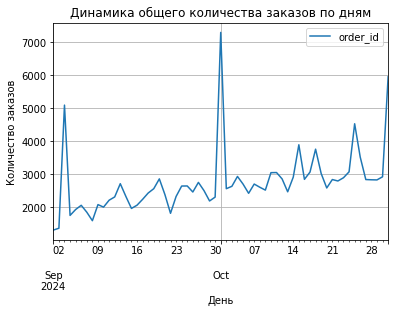

In [57]:
final_df_autumn_per_days = final_df_autumn_per_days.reset_index()
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='order_id', x='date')
plt.title('Динамика общего количества заказов по дням')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

<Figure size 1080x360 with 0 Axes>

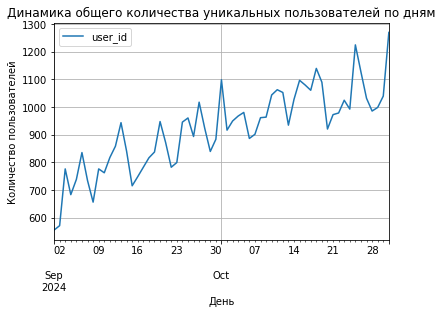

In [58]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='user_id', x='date')
plt.title('Динамика общего количества уникальных пользователей по дням')
plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()


<Figure size 1080x360 with 0 Axes>

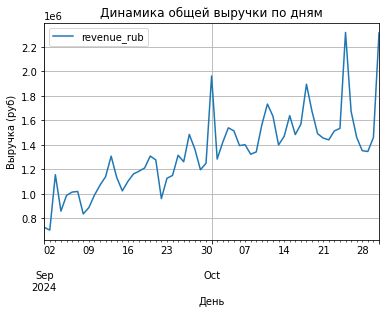

In [59]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='revenue_rub', x='date')
plt.title('Динамика общей выручки по дням')
plt.xlabel('День')
plt.ylabel('Выручка (руб)')
plt.grid()
plt.show()

<Figure size 1080x360 with 0 Axes>

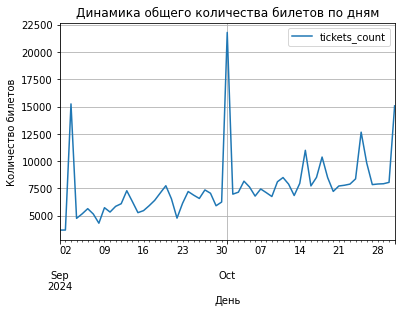

In [60]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='tickets_count', x='date')
plt.title('Динамика общего количества билетов по дням')
plt.xlabel('День')
plt.ylabel('Количество билетов')
plt.grid()
plt.show() 

<Figure size 1080x360 with 0 Axes>

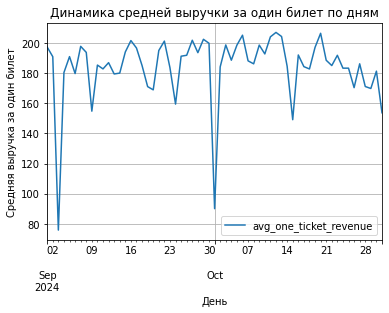

In [61]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='avg_one_ticket_revenue', x='date')
plt.title('Динамика средней выручки за один билет по дням')
plt.xlabel('День')
plt.ylabel('Средняя выручка за один билет')
plt.grid()
plt.show() 

<Figure size 1080x360 with 0 Axes>

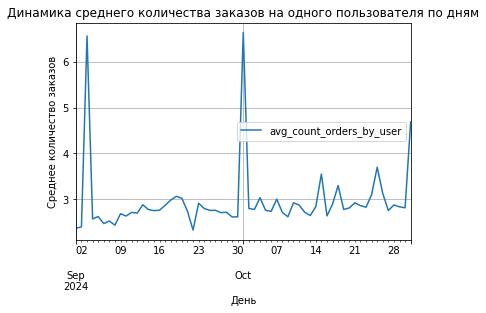

In [62]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_days.plot(kind='line', y='avg_count_orders_by_user', x='date')
plt.title('Динамика среднего количества заказов на одного пользователя по дням')
plt.xlabel('День')
plt.ylabel('Среднее количество заказов')
plt.grid()
plt.show()  

### Изучим недельную цикличность. Выделим день недели и сравните пользовательскую активность в будни и выходные.

In [63]:
final_df_autumn['day_of_week'] = final_df_autumn['created_dt_msk'].dt.day_name() 
# Переименуем названия дня недели на русский язык:
# Создаём словарь для переименования
day_names_map = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

# Применяем переименование
final_df_autumn['day_of_week'] = final_df_autumn['day_of_week'].map(day_names_map)
# Отсортируем данные с понедельника по воскресенье:
day_order = {
    'Понедельник': 1,
    'Вторник': 2,
    'Среда': 3,
    'Четверг': 4,
    'Пятница': 5,
    'Суббота': 6,
    'Воскресенье': 7
}

# Сортируем датафрейм по столбцу 'day_of_week' с использованием словаря
final_df_autumn = final_df_autumn.sort_values(by='day_of_week', key=lambda x: x.map(day_order))
# Добавим столбец с типом дня недели (будни, выходные)
final_df_autumn['day_type'] = final_df_autumn['day_of_week'].apply(lambda x: 'выходные' if x in ['Суббота', 'Воскресенье'] else 'будни')

# Группируем данные по дате и вычисляем нужные нам значения
final_df_autumn_per_day_of_week = final_df_autumn.groupby('day_type').agg({'order_id': 'count', 'user_id': 'nunique', 'revenue_rub':'sum', 'tickets_count':'sum'})

# Вычисляем среднее количество заказов на одного пользователя и среднюю выручку с одного билета
final_df_autumn_per_day_of_week['avg_count_orders_by_user'] = final_df_autumn_per_day_of_week['order_id'] / final_df_autumn_per_day_of_week['user_id']
final_df_autumn_per_day_of_week['avg_one_ticket_revenue'] = final_df_autumn_per_day_of_week['revenue_rub'] / final_df_autumn_per_day_of_week['tickets_count']
final_df_autumn_per_day_of_week = final_df_autumn_per_day_of_week.reset_index()
display(final_df_autumn_per_day_of_week)

/tmp/ipykernel_1468/1072190395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_autumn['day_of_week'] = final_df_autumn['created_dt_msk'].dt.day_name()
/tmp/ipykernel_1468/1072190395.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_autumn['day_of_week'] = final_df_autumn['day_of_week'].map(day_names_map)


,day_type,order_id,user_id,revenue_rub,tickets_count,avg_count_orders_by_user,avg_one_ticket_revenue
0,будни,127390,13184,6.002422e+07,348836.0,9.662470,172.070018
1,выходные,40406,7076,2.177637e+07,111590.0,5.710288,195.146285


- Построим визуализации для сравнения каждого значения по типу дня недели(будни/выходные)

<Figure size 1080x360 with 0 Axes>

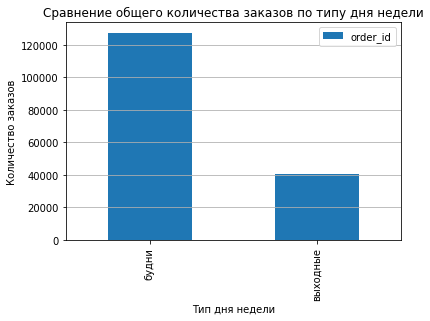

In [64]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='order_id')
plt.title(f'Сравнение общего количества заказов по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

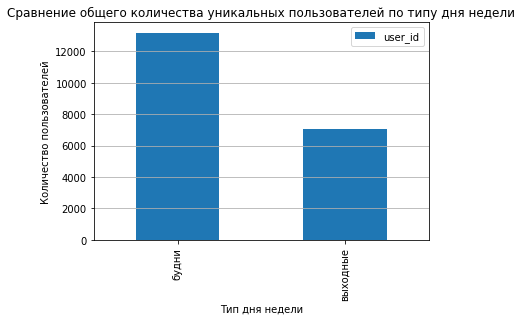

In [65]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='user_id')
plt.title(f'Сравнение общего количества уникальных пользователей по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

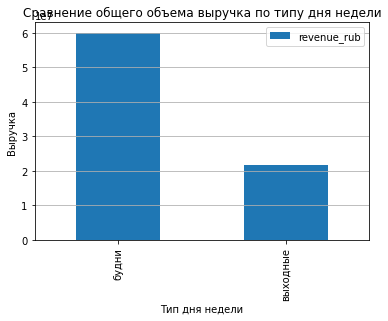

In [66]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='revenue_rub')
plt.title(f'Сравнение общего объема выручка по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Выручка')
plt.grid(axis='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

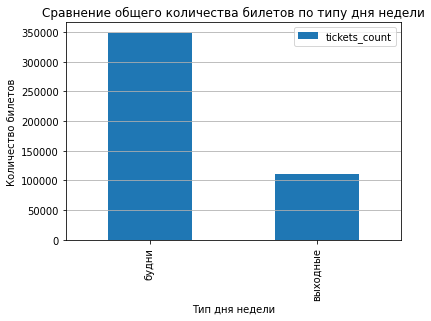

In [67]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='tickets_count')
plt.title(f'Сравнение общего количества билетов по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Количество билетов')
plt.grid(axis='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

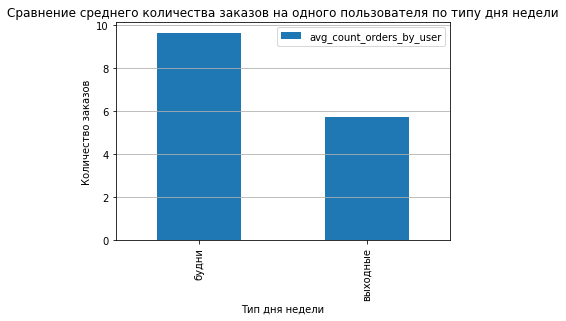

In [68]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='avg_count_orders_by_user')
plt.title(f'Сравнение среднего количества заказов на одного пользователя по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.show()

<Figure size 1080x360 with 0 Axes>

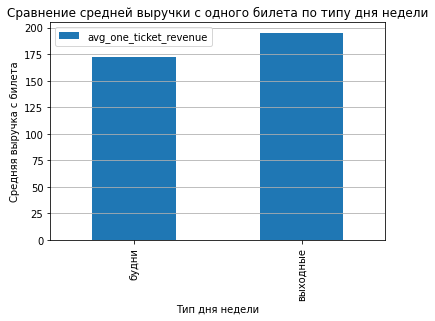

In [69]:
plt.figure(figsize=(15, 5))
final_df_autumn_per_day_of_week.plot(kind='bar', x='day_type', y='avg_one_ticket_revenue')
plt.title(f'Сравнение средней выручки с одного билета по типу дня недели')
plt.xlabel('Тип дня недели')
plt.ylabel('Средняя выручка с билета')
plt.grid(axis='y')
plt.show()

### Общие выводы по двум предыдущим пунктам:
- Анализ динамики по дням:
   - Общее количество заказов, количество уникальных пользователей, общая выручка, общее кол-во билетов - в целом, эти показатели растут;
   - По некоторым показателям наблюдаются значительные скачки в начале каждого месяца:
     - общее кол-во билетов - в начале каждого месяца резкие повышения и сразу же понижения, после чего следует постепенный рост;
     - средняя выручка с одного билета - резкие понижения в начале месяца, затем значение возвращается в более стабильное
     - среднее кол-во заказов на одного пользователя - в сентябре почти не превышает трех заказов, а в октябре периодически поднимается до 4х заказов. В начале месяца резкие повышения
   - Вероятно, в начале месяца действуют акции и глубокие скидки для пользователей, в связи с чем и наблюдается резкое повышение покупки билетов, количества заказов на одного пользователя и понижение выручки (вероятно, как раз за счет скидок: больше скидка = меньше выручка).
- Анализ активности пользователей по типу дня недели:
  - Почти по всем показателям выходит, что в будние дни пользователи более активны. В выходные дни только выручка с билета выше, но и заказов меньше, чем в будние дни

## Популярные события и партнёры

### Посмотрим, как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 
- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.
- Также расчитаем доли вышеперечисленных метрик от общего объема.

In [70]:
final_df_autumn_regions = final_df_autumn.groupby('region_name').agg({'event_id':'nunique', 'order_id':'count'})
final_df_autumn_regions = final_df_autumn_regions.sort_values(by = 'event_id', ascending = False)
final_df_autumn_regions['part_of_events'] = final_df_autumn_regions['event_id'] / final_df_autumn_regions['event_id'].sum()
final_df_autumn_regions['part_of_orders'] = final_df_autumn_regions['order_id'] / final_df_autumn_regions['order_id'].sum()
display(final_df_autumn_regions.head())

,event_id,order_id,part_of_events,part_of_orders
region_name,,,,
Каменевский регион,3893,46561,0.246892,0.277486
Североярская область,2594,20563,0.164510,0.122548
Широковская область,794,8645,0.050355,0.051521
Светополянский округ,755,4751,0.047882,0.028314
Речиновская область,529,3564,0.033549,0.021240


In [71]:
final_df_autumn_partners = final_df_autumn.groupby('service_name').agg({'event_id':'nunique', 'order_id':'count', 'revenue_rub':'sum'})
final_df_autumn_partners = final_df_autumn_partners.sort_values(by = 'revenue_rub', ascending = False)
final_df_autumn_partners['part_of_events'] = final_df_autumn_partners['event_id'] / final_df_autumn_partners['event_id'].sum()
final_df_autumn_partners['part_of_orders'] = final_df_autumn_partners['order_id'] / final_df_autumn_partners['order_id'].sum()
final_df_autumn_partners['part_of_revenue'] = (final_df_autumn_partners['revenue_rub'] / final_df_autumn_partners['revenue_rub'].sum()).round(4)
final_df_autumn_partners['revenue_rub'] = final_df_autumn_partners['revenue_rub'].round(2)
display(final_df_autumn_partners)

,event_id,order_id,revenue_rub,part_of_events,part_of_orders,part_of_revenue
service_name,,,,,,
Билеты без проблем,2818,31964,12106410.94,0.163933,0.190493,0.1480
Мой билет,1002,19395,10833849.28,0.058290,0.115587,0.1324
Облачко,1409,15478,10611051.69,0.081966,0.092243,0.1297
Лови билет!,3584,25706,10381135.77,0.208493,0.153198,0.1269
Весь в билетах,599,9416,9351278.66,0.034846,0.056116,0.1143
Билеты в руки,2445,25535,7611672.96,0.142234,0.152179,0.0931
Край билетов,193,2996,3016152.23,0.011227,0.017855,0.0369
Яблоко,537,3473,2763332.31,0.031239,0.020698,0.0338
Прачечная,728,5798,2548310.47,0.042350,0.034554,0.0312


- Построим графики распределения по ключевым показателям

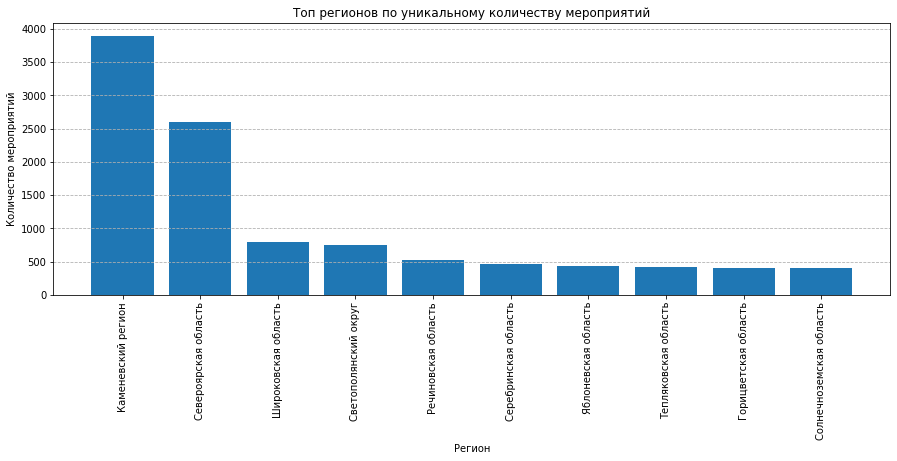

In [72]:
# Сортируем данные по количеству мероприятий в порядке убывания
sorted_regions = final_df_autumn_regions.sort_values(by='event_id', ascending=False)

# Выбираем топ-10 регионов
top_regions = sorted_regions.head(10)

# Строим график
plt.figure(figsize=(15, 5))
plt.bar(top_regions.index, top_regions['event_id'])
plt.title('Топ регионов по уникальному количеству мероприятий')
plt.xlabel('Регион')
plt.ylabel('Количество мероприятий')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

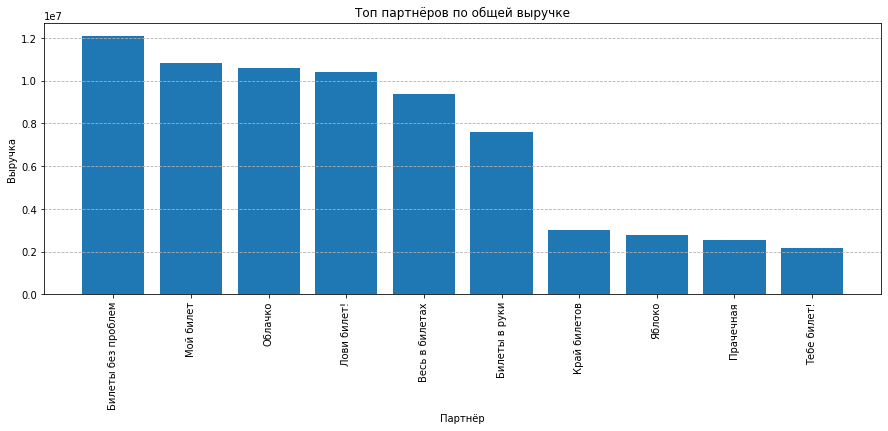

In [73]:
# Сортируем данные по выручке в порядке убывания
sorted_partners = final_df_autumn_partners.sort_values(by='revenue_rub', ascending=False)

# Выбираем топ-10 партнёров
top_partners = sorted_partners.head(10)

# Строим график
plt.figure(figsize=(15, 5))
plt.bar(top_partners.index, top_partners['revenue_rub'])
plt.title('Топ партнёров по общей выручке')
plt.xlabel('Партнёр')
plt.ylabel('Выручка')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()


### Вывод по топам:
- Среди регионов можно выделить топ-2 по количеству уникальных мероприятий:
  - 1 - Каменевский регион - 3893 уникальных мероприятия;
  - 2 - Североярская область - 2594 уникальных меропиятия.
- Среди партнеров можно выделить топ-6 по объему выручки(взял именно этот параметр, т.к. выручка - ключевой показатель):
  - 1 - Билеты без проблем - 12 106 370;
  - 2 - Мой билет - 10 833 720;
  - 3 - Облачко - 10 611 050;
  - 4 - Лови билет! - 10 381 140;
  - 5 - Весь в билетах - 9 350 394;
  - 6 - Билеты в руки - 7 610 798.
  


## Статистический анализ данных. Проверим несколько гипотез относительно активности пользователей мобильных и стационарных устройств

### Гипотеза 1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [74]:
# Разделим датафрейм на две группы по типу устройств
group_a = final_df_autumn[final_df_autumn['device_type_canonical'] == 'mobile']
group_b = final_df_autumn[final_df_autumn['device_type_canonical'] == 'desktop']

# Находим уникальные идентификаторы пользователей в каждой группе
group_a_unique_user_id = group_a['user_id'].unique()
group_b_unique_user_id = group_b['user_id'].unique()

# Определяем пересечение пользователей
intersection_users = set(group_a_unique_user_id) & set(group_b_unique_user_id)
print(intersection_users)

{'0204ecbadbe6616', 'fc4eef38f4b7fb5', 'ad315c028ec4545', '24a731b1d598f48', '34eb72aada5fa7f', 'f979b3e31d3b3cd', '5945ef27ea29124', '4e015d2150307c5', 'c087ecad30bb654', '39b1a6aa3d246ba', '2e64c88c4570e98', 'd6677fed53e63e2', 'aba4317051231ca', '0da8138bbc4a774', 'b5c27fea91cd0ee', 'ec2bc5a62c0c832', 'e5ce0cce41ae6ac', '0b9b8c1c4187ec8', 'd0b07146fd148a1', '27effa335c1c560', 'ee2c434861cf557', '708ae83aa902a7b', '5d262e40ec5b2a2', 'a04038531eb064f', 'fdc0dbdfe1c6938', '0203ca82fa4237c', 'a9ef6507906147a', '80084fa1664a54c', 'd5bfdd8b5254fbe', '142da01b54f4537', 'c8847bc86d34f85', '085bd9de4f80f59', '694442efd216a70', '4c287d557cee1ab', 'a2b00eebc13c0d5', '57ff2437f152580', '447ac88210b6d88', '8bb83f8c2b8b3bb', '167445a3502d8c4', '75713cdb9b94474', 'a77c589626f905f', 'f7ea5926e18e907', 'bcdc42173061238', '34f376ec432a38c', '975fd1266ad4a7f', 'd6ccb7a1cd0e953', '552f26149e05611', '9744259e073d126', 'e548f70173b1c40', '54e7a640ae1d135', '88ef1fc8304a1f5', '256df38ebfe4f1c', 'fe729d6c06

In [75]:
# Удаляем пересекающихся пользователей из исходных датафреймов
group_a_without_intersection = group_a[~group_a['user_id'].isin(intersection_users)]
group_b_without_intersection = group_b[~group_b['user_id'].isin(intersection_users)]
# Проверяем пересечение пользователей
intersection_users_after_removal = set(group_a_without_intersection['user_id']) & set(group_b_without_intersection['user_id'])
print(intersection_users_after_removal)

set()


- Пересечения удалены

In [76]:
# Подсчитываем количество заказов для каждого пользователя
orders_per_user_mobile = group_a_without_intersection.groupby('user_id').agg({'order_id':'count'})
orders_per_user_desktop = group_b_without_intersection.groupby('user_id').agg({'order_id':'count'})

# Вычисляем среднее количество заказов
average_orders_mobile = orders_per_user_mobile['order_id'].mean()
average_orders_desktop = orders_per_user_desktop['order_id'].mean()

print(f"Среднее количество заказов на одного пользователя мобильного приложения: {average_orders_mobile}")
print(f"Среднее количество заказов на одного пользователя стационарного устройства: {average_orders_desktop}")


Среднее количество заказов на одного пользователя мобильного приложения: 2.8675374850519733
Среднее количество заказов на одного пользователя стационарного устройства: 1.9710947109471095


- Проверим объем выборок:

In [77]:
gr_a = orders_per_user_mobile['order_id'].count()
print(f"Размер выборки группы А: {gr_a}")
gr_b = orders_per_user_desktop['order_id'].count()
print(f"Размер выборки группы А: {gr_b}")

Размер выборки группы А: 10871
Размер выборки группы А: 1626


- Размеры выборок сильно отличаются. Построим график для наглядности:

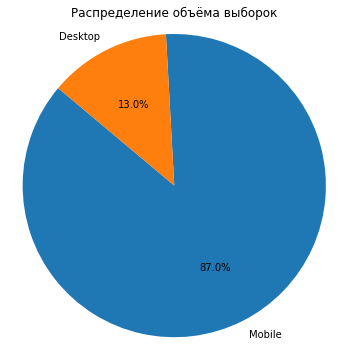

In [78]:
# Объёмы выборок
sizes = [gr_a, gr_b]

# Метки для диаграмм
labels = ['Mobile', 'Desktop']

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.title("Распределение объёма выборок")
plt.show()

- Проверим распределение в выборах:

#### Проверка гипотезы

Гипотеза звучит так: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств.

- Альтернативная гипотеза H₁: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

- Проведем тест Манна-Уитни в связи с наличием выборов

In [79]:
# Выполнение теста Манна — Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(orders_per_user_mobile, orders_per_user_desktop, alternative='greater')
if p_value > alpha:
    print(f'p-value теста Манна — Уитни = {round(float(p_value), 2)}')
    print('Нулевая гипотеза находит подтверждение! Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств')
else:
    print(f'p-value теста Манна — Уитни = {round(float(p_value), 2)}')
    print('Нулевая гипотеза не находит подтверждения! Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо')


p-value теста Манна — Уитни = 0.0
Нулевая гипотеза не находит подтверждения! Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо


### Гипотеза 2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [80]:
# Подсчитываем количество заказов для каждого пользователя
group_a_time = group_a_without_intersection['days_since_prev'].reset_index()
group_b_time = group_b_without_intersection['days_since_prev'].reset_index()
# Удалим пропуски из столбца days_since_prev
group_a_time = group_a_time.dropna() 
group_b_time = group_b_time.dropna()
# Вычисляем среднее время между заказами
average_days_since_prev_mobile = group_a_time['days_since_prev'].mean()
average_days_since_prev_desktop = group_b_time['days_since_prev'].mean()
print(f"Среднее время между заказами для мобильных устройств: {average_days_since_prev_mobile} дней")
print(f"Среднее время между заказами для стационарных устройств: {average_days_since_prev_desktop} дней")

Среднее время между заказами для мобильных устройств: 13.708844257954128 дней
Среднее время между заказами для стационарных устройств: 18.057019645424052 дней


- Проверим размеры выборок

In [81]:
gr_a_time = group_a_time['days_since_prev'].count()
print(f"Размер выборки группы А: {gr_a_time}")
gr_b_time = group_b_time['days_since_prev'].count()
print(f"Размер выборки группы А: {gr_b_time}")

Размер выборки группы А: 24547
Размер выборки группы А: 2087


- И снова, как и в случае с предыдущей гипотезой - размеры выборок сильно отличаются. Построим график для наглядности:

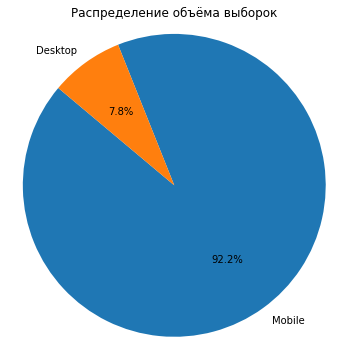

In [82]:
# Объёмы выборок
sizes = [gr_a_time, gr_b_time]  

# Метки для диаграмм
labels = ['Mobile', 'Desktop']

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.title("Распределение объёма выборок")
plt.show()

- Проверим распределение в выборах:

#### Проверка гипотезы

Гипотеза звучит так: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.

- Альтернативная гипотеза H₁: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

- Проведем тест Манна-Уитни в связи с наличием выборов

In [83]:
# Проводим тест Манна-Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(group_a_time['days_since_prev'], group_b_time['days_since_prev'], alternative='greater')

if p_value > alpha:
    print(f'p-value теста Манна — Уитни = {round(p_value, 2)}')
    print('Нулевая гипотеза находит подтверждение! Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств.')
else:
    print(f'p-value теста Манна — Уитни = {round(p_value, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо.')
 

p-value теста Манна — Уитни = 0.0
Нулевая гипотеза не находит подтверждения! Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо.


# Общие выводы и рекомендации


### Исследовали данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года:
  - провели предобработку данных, а именно: удалили часть пропусков; отчистили датафрейм от дубликатов; оптимизировали типы данных с понижением разрядности; обнаружили и устранили выбросы; дополнили датафрейм несколькими столбцами для дальнейшего исследовательского анализа; 
  - провели исследовательский анализ данных: распределения заказов по сегментам и их сезонные изменения; осенняя активность пользователей; популярные события и партнёры;
  - проверили гипотезы заказчика путем А/Б тестов.

### Основные результаты анализа: 
- наиболее востребованые мероприятия (посчитали в виде долей от общего числа мероприятий):
  - Концерты - доля заказов 0.44 летом, 0.37 осенью
  - Театры - доля заказов 0.25 осенью, 0.21 летом
- осенью популярность повысилась у следующих мероприятий:
  - театр - летом доля заказов 0.20, осенью 0.25
  - спорт - летом доля заказов 0.02, осенью 0.11
- самое заметное повышение стоимости среднего чека осенью наблюдается по категории мероприятий "стендап" (повышение на 6.25%)
- самая высокая активность пользователей выпадает на начало сентября и октября. Вероятно, в эти даты организаторы запускают акции и скидки, т.к. кол-во проданных билетов увеличивается, но и также резко падает выручка, что говорит о глубоких скидках. Далее видим повышение притока новых пользователей в течение всего времени наблюдения, что говорит о том, что акции/скидки, вероятно, влияют на привлечение (как и должно быть запланировано организаторами);
- среди регионов и партнёров существуют явные лидеры по числу заказов и выручке с продажи билетов:
  - среди регионов можно выделить топ-2 по количеству уникальных мероприятий:
    - 1 - Каменевский регион - 3893 уникальных мероприятия;
    - 2 - Североярская область - 2594 уникальных меропиятия.
  - среди партнеров можно выделить топ-6 по объему выручки(взял именно этот параметр, т.к. выручка - ключевой показатель):
    - 1 - Билеты без проблем - 12 106 370;
    - 2 - Мой билет - 10 833 720;
    - 3 - Облачко - 10 611 050;
    - 4 - Лови билет! - 10 381 140;
    - 5 - Весь в билетах - 9 350 394;
    - 6 - Билеты в руки - 7 610 798.
- по результату проверки двух гипотез, в обоих случаях нулевые гипотезы были отвергнуты в пользу альтернативных, а именно:
  - Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо
  - Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств, и это различие статистически значимо.

### На основе проведённого анализа можно дать следующие рекомендации и обратить внимание на ключевые аспекты:
- Анализ популярности мероприятий:
  - необходимо рассмотреть, с чем связано повышение популярности концертов и театров. Возможно, стоит планировать маркетинговые кампании и расписание мероприятий с учётом этих тенденций, а также проверить, применима ли та же логика к другим меропиятиям, дабы увеличить и их популярность;
- Акции и скидки:
  - судя по графикам - рост притока новых покупателей увеличивается, а это значит, что способы привлечения новых клиентов работают и их можно применять и дальше.
  - проверить, можно ли оптимизировать акции и скидки так, чтобы не было столь серьезного падения средней выручки за билет.
- Региональные различия:
  - Каменевский регион и Североярская область являются топовыми регионами по количеству мероприятий. Логично предположить, что спрос в этих регионах довольно высок и можно вложить ресурсы на развитие рынка именно в данных регионах.
  - не стоит забывать и про регионы с более низкими показателями, чем вышеперечисленные топ-2, но не в момент сезонности, как указано в предыстории задачи. Лучше уделить этому время уже после новогодних праздников. 
- Сотрудничество с партнёрами:
  - оцените эффективность сотрудничества с топовыми партнёрами по объёму выручки. Какие спообы применимы к ним, чтобы стимулировать их продолжать проявлять высокую активность по продаже билетов. Рассмотреть, какие типы мероприятий можно раскрутить с помощью топовых партнеров;
- Использование данных о поведении пользователей:
  - тесты показали, что с мобильного приложения формируется больше заказов на одного пользователя, чем со стационарного устройства, но в то же время и время между заказами с мобильных приложений выше. Нужно проверить техническую часть приложения: на каких этапах у пользователей могут возникать задержки/баги и т.п. и устранить их. Также стимулировать пользователей возвращаться в приложение чаще, например, с помощью акций, индивидуальных предложений на основе предпочтений пользователей.